In [1]:
# import our python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
from astropy.table import Table, Column
from scipy import optimize
import math
import json

In [2]:
asciiLC = 'supernova1b_template.dat'
filterNames = ['u', 'g', 'r', 'i', 'z']
colors = {'u':'purple','g':'g','r':'r','i':'blue','z':'m'}
location_of_peak = np.arange(59700, 60100, 30)
height_of_peak = np.arange(17,21,1)

In [3]:
# Set the database and query
runName = 'minion_1016'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')

# Set the output directory
outDir = 'Observations Dictionary'
resultsDb = db.ResultsDb(outDir)

In [4]:
# The pass metric just passes data straight through.
#choose database and restrictions (such as list of ra and dec)
metric = metrics.PassMetric(cols=['expMJD','filter','fiveSigmaDepth'])
slicer = slicers.UserPointsSlicer(np.random.uniform(0,360,1000), np.random.uniform(-60,-30,1000))
#slicer = slicers.UserPointsSlicer(0, -45)
#no restrictions currently
sql = ''
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb,
                                        outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [5]:
def createdict_for_mjd_filter_depth(bundle):
    
    """This function returns a list of tables of exposure day, filter, 
    and five sigma depth for each ra and dec chosen"""
    
    listofDict = []
    for coord in range(len(bundle.metricValues)):
        bdict = {key: bundle.metricValues[coord][key] for 
                 key in ['fieldRA', 'fieldDec', 'expMJD', 'filter', 'fiveSigmaDepth']}
        t = Table(bdict)
        t.rename_column('expMJD', 'day')
        t = t[t['filter'] != 'y']
        t.sort('day')
        listofDict.append(t)
    return listofDict

In [6]:
def read_lightcurve(asciifile, f):
    skip = 0
    if f == 'u':
        columns = (0,1,2)
        skip = 40
    elif f == 'g':
        columns = (3,4,5)
    elif f == 'r':
        columns = (6,7,8)
    elif f == 'i':
        columns = (9,10,11)
    elif f == 'z':
        columns = (12,13,14)
    else:
        pass
    #Reads asciifile - three columns (phase, magnitude, filter)
    lc = np.genfromtxt(asciifile, dtype=[('day', np.float), ('mag', np.float), ('error', np.float)],
                       skip_header = 1, skip_footer = skip, usecols = columns)

    return {f:lc}

In [7]:
def add_data_to_lc_table(asciiLC, template):
    '''This function returns a table with phase, magnitude, and filter for a light curve read
    in from an ascii file'''
    for f in filterNames:  
        curvedata = read_lightcurve(asciiLC, f)
        bdict = {key: curvedata[f][key] for key in ['day', 'mag', 'error']}
        t = Table(bdict)
        t['filter'] = f
        for row in range(len(t)):
            t['mag'][row] = -2.5*math.log10(t['mag'][row])
            template.add_row(t[row])
    template.sort('day')
    return template

In [8]:
def normalize_template(template):
    peaktable = peak_brightness(template)
    peakmag = peaktable['g'][1]
    template['mag'] -= peakmag
    return template

In [9]:
def peak_brightness(template):
    
    """This function returns a table of peak magnitude and the day it occurs 
    for each filter from the read in lightcurve"""
    
    peak_brightness = {}
    for f in filterNames:
        fMatch = np.where(template['filter'] == f)
        maxmag = np.amin(template['mag'][fMatch])
        location = np.argmin(template['mag'][fMatch])
        maxday = template['day'][fMatch][location]
        peak_brightness[f] = [maxday, maxmag]
    
    peak = Table(peak_brightness)
    peak[' '] = ['day', 'mag']
    orderedPeak = peak[' ','u','g','r','i','z']
    return orderedPeak

In [10]:
def adjust_peak(template, peakday, peakmag):
    adjusted_template = template.copy()
    """This function finds the necessary adjustment needed to make the peak 
    of the red filter occur at the right place and adjusts all filters by that same ammount"""
    
    adjusted_template['day'] += peakday
    adjusted_template['mag'] += peakmag
    
    return adjusted_template

In [11]:
def adjust_opsim_table(opsim, adjusted_template):
    new_opsim = opsim.copy()
    new_opsim = new_opsim[new_opsim['day']< adjusted_template['day'].max()]
    new_opsim = new_opsim[new_opsim['day']> adjusted_template['day'].min()]
    return new_opsim

In [12]:
def interpolate_light_curve(adjusted_template, new_opsim):
    
    #for each filter interpolate the read in light curve to the days of the opsim in all filters
    
    lc = {}
    for f in filterNames:
        fMatch = np.where(adjusted_template['filter'] == f)
        lc[f] = np.interp(new_opsim['day'], adjusted_template['day'][fMatch], adjusted_template['mag'][fMatch])
    lightcurve = Table(lc)
    lightcurve['day'] = new_opsim['day']
    lightcurve = lightcurve['day', 'u', 'g', 'r', 'i', 'z']
    return lightcurve

In [13]:
def resample_light_curve(lightcurve, new_opsim):
    
    """add to the opsim table a magnitude column where the magnitude is taken 
    from the index of the interpolated light curve where both the filter and day matched the opsim"""
    
    new_opsim['magnitude'] = 0.
    for row in range(len(new_opsim)):
        filterName = new_opsim['filter'][row]
        new_opsim['magnitude'][row] = lightcurve[filterName][row]
    return new_opsim

In [14]:
def calculate_error(new_opsim):
    
    #Calculate the error of the magnitude at each point from the magnitude and fiveSigmaDepth stored in opsim
    
    snr = 5.*10.**(-0.4*(new_opsim['magnitude'] - new_opsim['fiveSigmaDepth']))
    lc_err = 2.5/(np.log(10)*snr)
    new_opsim['error'] = lc_err
    
    return new_opsim

In [15]:
def magnitude_distribution(new_opsim):
    new_opsim['magnitude'] = np.random.normal(new_opsim['magnitude'], new_opsim['error'])
    return new_opsim

In [16]:
def func_per_filter(f):
    def func(time, peak_mag, peak_time):
        new_template = template.copy()
        new_template['mag'] += peak_mag
        new_template['day'] += peak_time
        fMatch = np.where(new_template['filter'] == f)
        model = np.interp(time, new_template['day'][fMatch], new_template['mag'][fMatch],left=99,right=99)
        return model
    return func

In [17]:
def fit_curve(opsim_fmatch2, f):
    initial_parameters = [opsim_fmatch2['magnitude'].min(), 
                          opsim_fmatch2['day'][opsim_fmatch2['magnitude'].argmin()]]
    popt, pcov = optimize.curve_fit(func_per_filter(f), opsim_fmatch2['day'], opsim_fmatch2['magnitude'], 
                                    p0 = initial_parameters, sigma = opsim_fmatch2['error'])
    return popt

In [18]:
def func2(x, a, b, c, x0):
    return a*(x-x0)**2 + b*(x-x0) + c

In [19]:
def fit_curve2(opsim_fmatch, template_fmatch2):
    opsim_fmatch = opsim_fmatch[opsim_fmatch['day'] <= template_fmatch2['day'].max()]
    peak_day = opsim_fmatch['day'][opsim_fmatch['magnitude'].argmin()]
    peak_mag = opsim_fmatch['magnitude'].min()
    x_min = opsim_fmatch['day'].min()
    y_min = opsim_fmatch['magnitude'][opsim_fmatch['day'].argmin()]
    x_max = opsim_fmatch['day'].max()
    y_max = opsim_fmatch['magnitude'][opsim_fmatch['day'].argmax()]
    if x_min != peak_day:
        a = (y_min - peak_mag) / (x_min - peak_day)**2
    else:
        a = (y_max - peak_mag) / (x_max - peak_day)**2
    initial_parameters = [a, 0, peak_mag, peak_day]
    popt, pcov = optimize.curve_fit(func2, opsim_fmatch['day'], opsim_fmatch['magnitude'], 
                                    p0 = initial_parameters, sigma = opsim_fmatch['error'])
    return popt

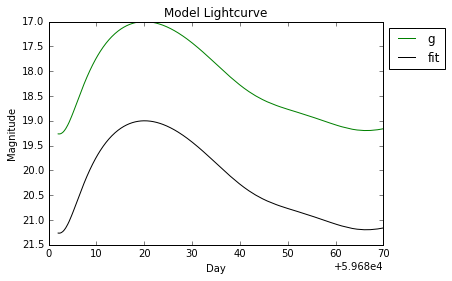

In [20]:
template = Table(names=('day', 'mag', 'error', 'filter'), 
                       dtype=('float', 'float', 'float', 'string'))
template = add_data_to_lc_table(asciiLC, template)
template = normalize_template(template)
peakday = 59700
peakmag = 17
adjusted_template = adjust_peak(template, peakday, peakmag)

model_per_filter = func_per_filter('g')
f = 'g'
filter_match = np.where(adjusted_template['filter'] == f)
plt.errorbar(adjusted_template['day'][filter_match], adjusted_template['mag'][filter_match], 
             color=colors[f], label = f)
plt.errorbar(adjusted_template['day'][filter_match], model_per_filter(adjusted_template['day'][filter_match], 19, 59700), 
             color='black', label = 'fit')
plt.ylim(plt.ylim()[::-1])
plt.title('Model Lightcurve')
plt.xlabel('Day')
plt.ylabel('Magnitude')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))


In [20]:
def create_curve(f, ra, dec, peakday, peakmag, opsim_fmatch2, template_fmatch2, xdata, popt):
    plt.plot(xdata, func_per_filter(f)(xdata, *popt), 'black' , label='fit')
    plt.errorbar(opsim_fmatch2['day'], opsim_fmatch2['magnitude'], 
                   yerr = opsim_fmatch2['error'], fmt = 'o', color=colors[f], label=f)
    plt.plot(template_fmatch2['day'], template_fmatch2['mag'], 
                     color=colors[f], label=f)
    plt.xlabel('day')
    plt.ylabel('magnitude')
    plt.ylim(22,15)
    plt.legend(numpoints = 1)
    plt.title('Lightcurve at ra = %r and dec = %r, peakday = %r and peakmag = %r'
              %(round(ra,3), round(dec,3), peakday, peakmag))
    plt.show()

In [21]:
def create_curve2(f, ra, dec, peakday, peakmag, opsim_fmatch2, template_fmatch2, xdata, popt2):
    plt.plot(xdata, func2(xdata, *popt2), 'teal', label = 'poly')
    plt.errorbar(opsim_fmatch2['day'], opsim_fmatch2['magnitude'], 
                   yerr = opsim_fmatch2['error'], fmt = 'o', color=colors[f], label=f)
    plt.plot(template_fmatch2['day'], template_fmatch2['mag'], 
                     color=colors[f], label=f)
    plt.xlabel('day')
    plt.ylabel('magnitude')
    plt.ylim(22,15)
    plt.legend(numpoints = 1)
    plt.title('Lightcurve at ra = %r and dec = %r, peakday = %r and peakmag = %r'
              %(round(ra,3), round(dec,3), peakday, peakmag))
    plt.show()

In [22]:
def resampled_peak_magnitude(ra, dec, f, template_fmatch2, xdata, popt, popt2):
    
    peak_magnitude_difference_shift = template_fmatch2['mag'].min() - func_per_filter(f)(xdata, *popt).min()
    
    peak_magnitude_difference_poly = template_fmatch2['mag'].min() - func2(xdata, *popt2).min()

    return [ra, dec, f, peak_magnitude_difference_shift, peak_magnitude_difference_poly]

In [23]:
def resampled_peak_day(ra, dec, f, template_fmatch2, xdata, popt, popt2):

    actual_peak_day = template_fmatch2['day'][template_fmatch2['mag'].argmin()]
    
    fitted_peak_day_shift = func_per_filter(f)(xdata, *popt).argmin() + xdata.min()
    peak_day_difference_shift = actual_peak_day - fitted_peak_day_shift
    
    fitted_peak_day_poly = func2(xdata, *popt2).argmin() + xdata.min()
    peak_day_difference_poly = actual_peak_day - fitted_peak_day_poly
    
    return [ra, dec, f, peak_day_difference_shift, peak_day_difference_poly]

In [24]:
def create_peak_difference_table(peak):

    peak_difference = Table(names=('ra', 'dec', 'filter', peak + ' 1', peak + ' 2'), 
                                dtype=('float', 'float', 'string', 'float', 'float'))
    return peak_difference

In [25]:
survey = createdict_for_mjd_filter_depth(bundle)

In [26]:
from astropy.io import ascii
file1 = open("results_per_filter.txt", "w+")
peak1 = 'peak magnitude difference'
peak2 = 'peak day difference'
percent_table = Table(names=('ra', 'dec', 'percent template', 'percent polynomial'), 
                                dtype=('float', 'float', 'float', 'float'))
template = Table(names=('day', 'mag', 'error', 'filter'), 
                       dtype=('float', 'float', 'float', 'string'))
template = add_data_to_lc_table(asciiLC, template)
peaktable = peak_brightness(template)
template = normalize_template(template)
peak_guess_table = Table(names=('ra', 'dec', 'filter', 'peakday', 'peakmag', 'peakday template', 'peakmag template',
                               'peakday poly', 'peakmag poly'), dtype=('float', 'float', 'string', 'float', 'float', 'float', 
                                                                      'float', 'float', 'float'))
peak_mag_difference_template = create_peak_difference_table(peak1)
peak_day_difference_template = create_peak_difference_table(peak2)
peak_mag_difference_poly = create_peak_difference_table(peak1)
peak_day_difference_poly = create_peak_difference_table(peak2)
strong_template = 0
strong_polynomial = 0
weak = 0
bad_fit_template = 0
bad_fit_polynomial = 0
unobserved = 0
bad = 0.
good = 0.
results = []
for coord in range(len(bundle.metricValues)):
    enough_template = 0.
    not_enough_template = 0.
    enough_poly = 0.
    not_enough_poly = 0.
    opsim = survey[coord]
    ra = np.degrees(opsim['fieldRA'][0])
    dec = np.degrees(opsim['fieldDec'][0])
    for f in filterNames:
        for peakday in location_of_peak:
            for peakmag in height_of_peak:
                adjusted_template = adjust_peak(template, peakday, peakmag)
                new_opsim = adjust_opsim_table(opsim, adjusted_template)
                if len(new_opsim) == 0:
                    unobserved += 1
                    not_enough_template += 1
                    not_enough_poly += 1
                    peak_guess_table.add_row([ra,dec,f,peakday,peakmag,0,0,0,0])
                else:
                    lightcurve = interpolate_light_curve(adjusted_template, new_opsim)
                    new_opsim = resample_light_curve(lightcurve, new_opsim)
                    new_opsim = calculate_error(new_opsim)
                    new_opsim = magnitude_distribution(new_opsim)
                    final_opsim = new_opsim.copy()
                    final_opsim = final_opsim[final_opsim['day'] <= (30 + adjusted_template['day'].min())]
                    fMatch = np.where(final_opsim['filter'] == f)
                    opsim_fmatch = final_opsim[fMatch]
                    opsim_fmatch['day'] = np.round(opsim_fmatch['day'])
                    if len(np.unique(opsim_fmatch['day'])) >= 4:
                        fMatch2 = np.where(new_opsim['filter'] == f)
                        opsim_fmatch2 = new_opsim[fMatch2]
                        fMatch3 = np.where(template['filter'] == f)
                        template_fmatch = template[fMatch3]
                        fMatch4 = np.where(adjusted_template['filter'] == f)
                        template_fmatch2 = adjusted_template[fMatch4]
                        
                        xdata = np.arange(template_fmatch2['day'].min(), template_fmatch2['day'].max(), 1)
                        popt = fit_curve(opsim_fmatch2, f)
                        popt2 = fit_curve2(opsim_fmatch, template_fmatch2)
                        
                        fitted_peak_day_poly = func2(xdata, *popt2).argmin() + xdata.min()
                        peak_magnitude_poly = func2(xdata, *popt2).min()
                        peak_guess_table.add_row([ra,dec,f,peakday,peakmag,popt[1],popt[0],fitted_peak_day_poly, 
                                                  peak_magnitude_poly])
                        
                        peak_mag_list = resampled_peak_magnitude(ra, dec, f, template_fmatch2, xdata, popt, popt2)
                        peak_day_list = resampled_peak_day(ra, dec, f, template_fmatch2, xdata, popt, popt2)
                        if abs(peak_mag_list[3]) > 0.5 or abs(peak_day_list[3]) > 5:
                            #create_curve(f, ra, dec, peakday, peakmag, 
                            #    opsim_fmatch2, template_fmatch2, xdata, popt)
                            bad_fit_template += 1
                            not_enough_template += 1
                            good += 1
                        else:
                            peak_mag_difference_template.add_row(peak_mag_list)
                            peak_day_difference_template.add_row(peak_day_list)
                            strong_template += 1
                            enough_template += 1
                            good += 1
                        if abs(peak_mag_list[4]) > 0.5 or abs(peak_day_list[4]) > 5:
                            #create_curve2(f, ra, dec, peakday, peakmag, 
                            #    opsim_fmatch2, template_fmatch2, xdata, popt2)
                            bad_fit_polynomial += 1
                            not_enough_poly += 1
                        else:
                            peak_mag_difference_poly.add_row(peak_mag_list)
                            peak_day_difference_poly.add_row(peak_day_list)
                            strong_polynomial += 1
                            enough_poly += 1
                    else:
                        weak += 1
                        not_enough_template += 1
                        not_enough_poly += 1
                        bad += 1
                        peak_guess_table.add_row([ra,dec,f,peakday,peakmag,0,0,0,0])
ascii.write(peak_guess_table, file1)
file1.flush()
              

/home/hbowden/lsst4/Linux64/miniconda2/4.2.12.lsst1/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [27]:
'''print percent_table
print(np.average(percent_table['percent template']))
print(np.average(percent_table['percent polynomial']))'''
file1 = open("general_results_per_filter.txt", "w+")
file1.write("unobserved = %d \n" %(unobserved))
file1.write("weak = %d \n" %(weak))
file1.write("strong template = %d \n" %(strong_template))
file1.write("bad fit template = %d \n" %(bad_fit_template))
file1.write("strong polynomial = %d \n" %(strong_polynomial))
file1.write("bad_fit_polynomial = %d \n" %(bad_fit_polynomial))
file1.write("percent with sufficient points = %d \n" %((good/(good+bad))*100))
file1.flush()

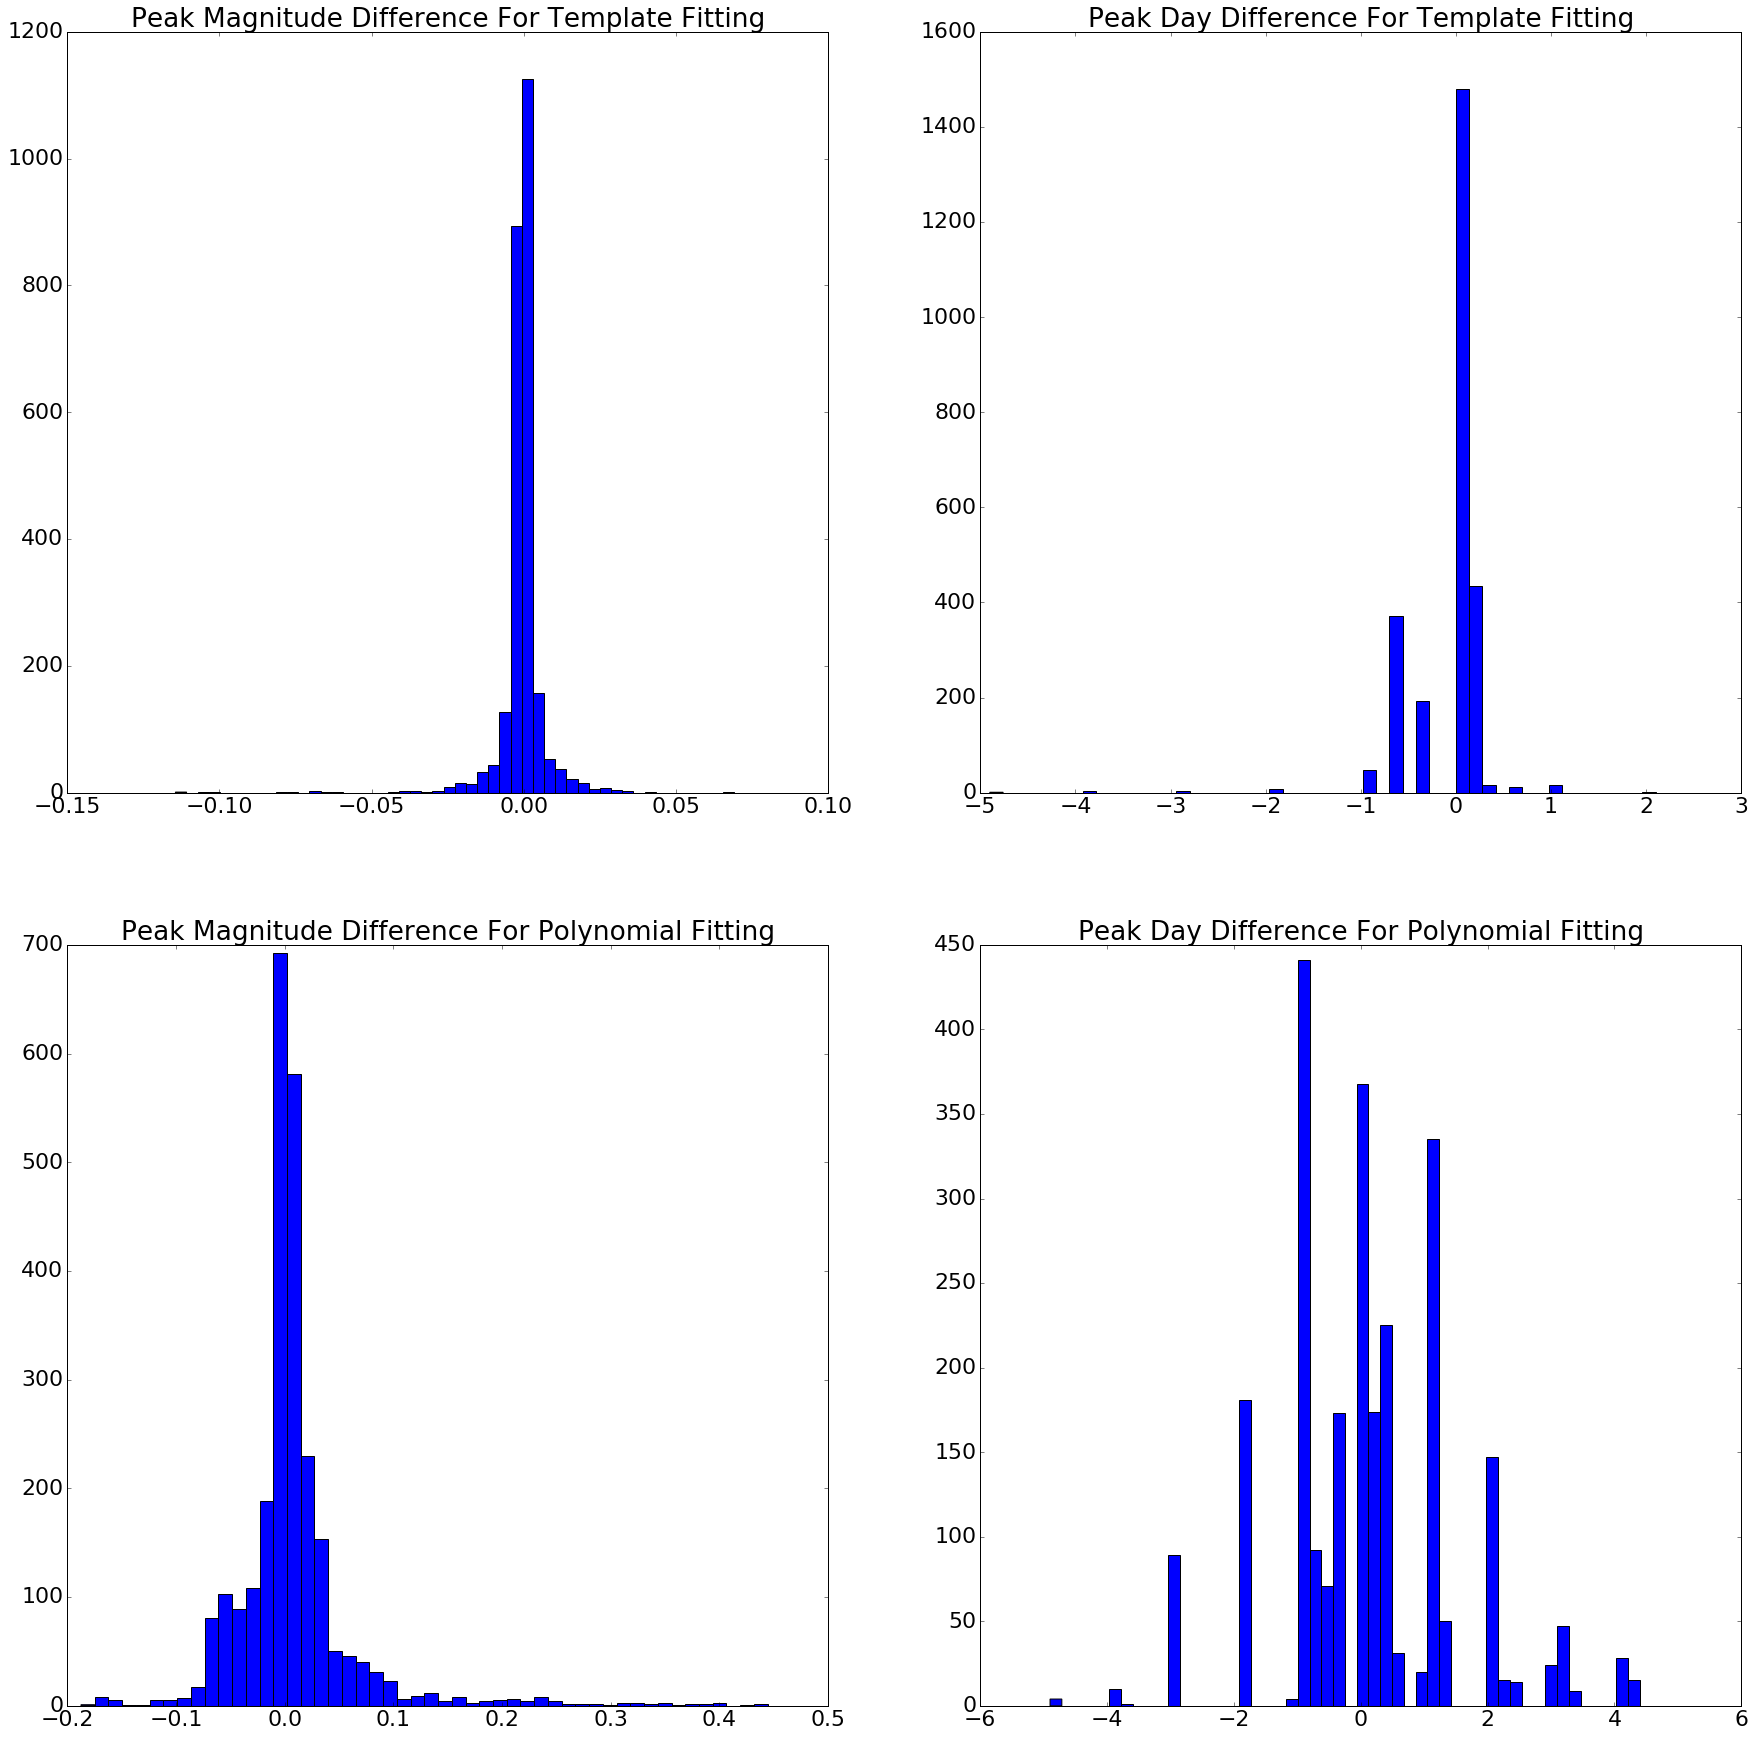

In [28]:
plt.rcParams.update({'font.size': 22})
f, axarr = plt.subplots(2,2,figsize=(30,30))
axarr[0,0].hist(peak_mag_difference_template['peak magnitude difference 1'], bins = 50)
axarr[0,0].set_title('Peak Magnitude Difference For Template Fitting')
axarr[0,1].hist(peak_day_difference_template['peak day difference 1'], bins = 50)
axarr[0,1].set_title('Peak Day Difference For Template Fitting')
axarr[1,0].hist(peak_mag_difference_poly['peak magnitude difference 2'], bins = 50)
axarr[1,0].set_title('Peak Magnitude Difference For Polynomial Fitting')
axarr[1,1].hist(peak_day_difference_poly['peak day difference 2'], bins = 50)
axarr[1,1].set_title('Peak Day Difference For Polynomial Fitting')
#f.subplots_adjust(hspace=1.0, wspace = 1.0)
f.savefig("results_histograms.pdf")

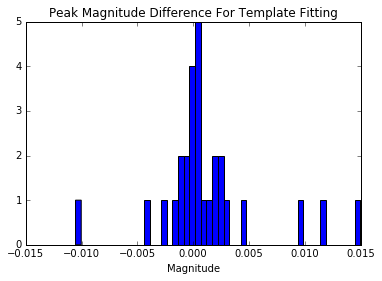

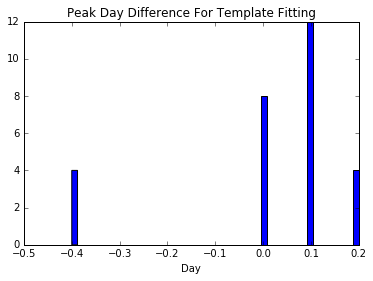

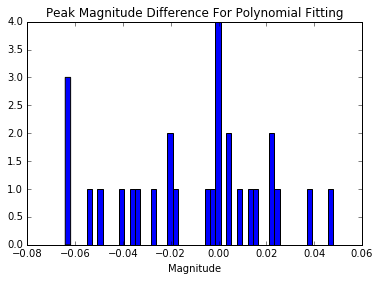

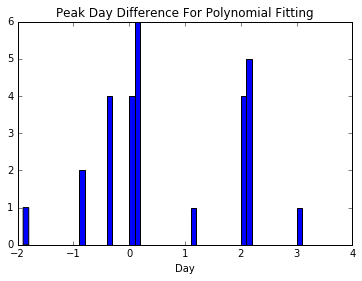

In [62]:
f1 = plt.figure()
plt.hist(peak_mag_difference_template['peak magnitude difference 1'], bins = 50)
plt.title('Peak Magnitude Difference For Template Fitting')
plt.xlabel('Magnitude')
f1.savefig("peak_mag_template_hist.pdf")

f2 = plt.figure()
plt.hist(peak_day_difference_template['peak day difference 1'], bins = 50)
plt.title('Peak Day Difference For Template Fitting')
plt.xlabel('Day')
f2.savefig("peak_day_template_hist.pdf")

f3 = plt.figure()
plt.hist(peak_mag_difference_poly['peak magnitude difference 2'], bins = 50)
plt.title('Peak Magnitude Difference For Polynomial Fitting')
plt.xlabel('Magnitude')
f3.savefig("peak_mag_poly_hist.pdf")

f4 = plt.figure()
plt.hist(peak_day_difference_poly['peak day difference 2'], bins = 50)
plt.title('Peak Day Difference For Polynomial Fitting')
plt.xlabel('Day')
f4.savefig("peak_day_poly_hist.pdf")

In [38]:
template = Table(names=('day', 'mag', 'error', 'filter'), 
                       dtype=('float', 'float', 'float', 'string'))
template = add_data_to_lc_table(asciiLC, template)
peaktable = peak_brightness(template)
template = normalize_template(template)

for f in filterNames:
    good = 0.
    bad = 0.
    undetected = 0.

    for coord in range(len(bundle.metricValues)):

        opsim = survey[coord]
        ra = np.degrees(opsim['fieldRA'][0])
        dec = np.degrees(opsim['fieldDec'][0])


        for peakday in location_of_peak:

            for peakmag in height_of_peak:

                adjusted_template = adjust_peak(template, peakday, peakmag)
                new_opsim = adjust_opsim_table(opsim, adjusted_template)

                if len(new_opsim) == 0:
                    undetected += 1            
                else:
                    lightcurve = interpolate_light_curve(adjusted_template, new_opsim)
                    new_opsim = resample_light_curve(lightcurve, new_opsim)
                    new_opsim = calculate_error(new_opsim)
                    new_opsim = magnitude_distribution(new_opsim)
                    final_opsim = new_opsim.copy()
                    final_opsim = final_opsim[final_opsim['day'] <= (30 + adjusted_template['day'].min())]
                    fMatch = np.where(final_opsim['filter'] == f)
                    opsim_fmatch = final_opsim[fMatch]
                    opsim_fmatch['day'] = np.round(opsim_fmatch['day'])

                    if len(np.unique(opsim_fmatch['day'])) >= 4:
                        good += 1
                    else:
                        bad += 1

    percent = (good/(good+bad))*100
    print('filter = %s, percent = %r' %(f,percent))

filter = u, percent = 0.5344995140913509
filter = g, percent = 0.5928085519922255
filter = r, percent = 1.0689990281827018
filter = i, percent = 1.292517006802721
filter = z, percent = 3.498542274052478


In [ ]:
location_of_peak = [60000]
height_of_peak = [17]
template = Table(names=('day', 'mag', 'error', 'filter'), 
                       dtype=('float', 'float', 'float', 'string'))
template = add_data_to_lc_table(asciiLC, template)
peaktable = peak_brightness(template)
template = normalize_template(template)

for coord in range(len(bundle.metricValues)):
    good = 0.
    bad = 0.
    
    for f in filterNames:
        
        opsim = survey[coord]
        ra = np.degrees(opsim['fieldRA'][0])
        dec = np.degrees(opsim['fieldDec'][0])


        for peakday in location_of_peak:

            for peakmag in height_of_peak:

                adjusted_template = adjust_peak(template, peakday, peakmag)
                new_opsim = adjust_opsim_table(opsim, adjusted_template)

                if len(new_opsim) == 0:
                    bad += 1            
                else:
                    lightcurve = interpolate_light_curve(adjusted_template, new_opsim)
                    new_opsim = resample_light_curve(lightcurve, new_opsim)
                    new_opsim = calculate_error(new_opsim)
                    new_opsim = magnitude_distribution(new_opsim)
                    final_opsim = new_opsim.copy()
                    final_opsim = final_opsim[final_opsim['day'] <= (30 + adjusted_template['day'].min())]
                    fMatch = np.where(final_opsim['filter'] == f)
                    opsim_fmatch = final_opsim[fMatch]
                    opsim_fmatch['day'] = np.round(opsim_fmatch['day'])

                    if len(np.unique(opsim_fmatch['day'])) >= 4:
                        fMatch2 = np.where(new_opsim['filter'] == f)
                        opsim_fmatch2 = new_opsim[fMatch2]
                        fMatch3 = np.where(template['filter'] == f)
                        template_fmatch = template[fMatch3]
                        fMatch4 = np.where(adjusted_template['filter'] == f)
                        template_fmatch2 = adjusted_template[fMatch4]
                        xdata = np.arange(template_fmatch2['day'].min(), template_fmatch2['day'].max(), 1)
                        popt = fit_curve(opsim_fmatch2, f)
                        popt2 = fit_curve2(opsim_fmatch, template_fmatch2)
                        peak_day_list = resampled_peak_day(ra, dec, f, template_fmatch2, xdata, popt, popt2)
                        peak_mag_list = resampled_peak_magnitude(ra, dec, f, template_fmatch2, 
                                                             xdata, popt, popt2)
                        if abs(peak_mag_list[3]) > 0.5 or abs(peak_day_list[3]) > 5:
                            #create_curve(f, ra, dec, peakday, peakmag, 
                            #    opsim_fmatch2, template_fmatch2, xdata, popt)
                            good += 1
                        else:
                            peak_mag_difference_template.add_row(peak_mag_list)
                            peak_day_difference_template.add_row(peak_day_list)
                            good += 1
                        if abs(peak_mag_list[4]) > 0.5 or abs(peak_day_list[4]) > 5:
                            #create_curve2(f, ra, dec, peakday, peakmag, 
                            #    opsim_fmatch2, template_fmatch2, xdata, popt2)
                            pass
                        else:
                            peak_mag_difference_poly.add_row(peak_mag_list)
                            peak_day_difference_poly.add_row(peak_day_list)
                    else:
                        bad += 1

    percent = (good/(good+bad))*100
    print('ra = %r, dec = %r, percent = %r' %(round(ra,3), round(dec,3), percent))

In [103]:
model = Table(names=('day', 'mag', 'error', 'filter'), 
                       dtype=('float', 'float', 'float', 'string'))
model = add_data_to_lc_table(asciiLC, template)

In [104]:
def make_template_3d(time, time_shift, mag_shift):
    new_model = model.copy()
    new_model['day'] += time_shift
    new_model['mag'] += mag_shift
    template = np.zeros(time.shape)
    for i,f in enumerate(filterNames):
        template[i][time[i] > 0] = np.interp(time[i][time[i] > 0], new_model['day'][new_model['filter'] == f], 
                                             new_model['mag'][new_model['filter'] == f])
    return template

In [105]:
def resample_lc_3d(opsim, model, time_shift, mag_shift):
    new_model = model.copy()
    new_model['day'] += time_shift
    new_model['mag'] += mag_shift
    maxlength = np.max([sum(opsim['filter'] == f) for f in filterNames])
    resampled_mjd = np.zeros((5, maxlength))
    resampled_mag = np.zeros((5, maxlength))
    resampled_sig = np.zeros((5, maxlength)) + 1000
    for i,f in enumerate(filterNames):
        filter_match = opsim['filter'] == f
        n_samples_in_filter = filter_match.sum()
        model_filter_match = new_model['filter'] == f
        mjds =  opsim['day'][filter_match]
        mags = np.interp(mjds, new_model[model_filter_match]['day'],
                         new_model[model_filter_match]['mag'], left=99, right=99)
        # Trim off visits where the template doesn't exist
        detections = mags < 30
        mags = mags[detections]
        mjds = mjds[detections]
        five_sigma = opsim['fiveSigmaDepth'][filter_match][detections]
        
        snr = 5*(10**((-0.4)*(mags - five_sigma)))
        mag_err = 2.5/(snr*np.log(10))
        
        good_detections = mag_err < 0.3
        n_good_detections = good_detections.sum()
        resampled_mjd[i][:n_good_detections] = mjds[good_detections]
        resampled_sig[i][:n_good_detections] = mag_err[good_detections]
        resampled_mag[i][:n_good_detections] = np.random.normal(mags[good_detections], mag_err[good_detections])
    
    return resampled_mjd, resampled_mag, resampled_sig

In [107]:
def lnlike(theta, x, y, yerr):
    mjd, mag = theta
    m = make_template_3d(x, mjd, mag)
    inv_sigma2 = 1.0 /(yerr**2)
    return -0.5*(np.sum((y-m)**2*inv_sigma2 - np.log(inv_sigma2)))

In [244]:
#f = open("results_all_filters", "w+")
model = Table(names=('day', 'mag', 'error', 'filter'), 
                       dtype=('float', 'float', 'float', 'string'))
model = add_data_to_lc_table(asciiLC, template)
peaktable = peak_brightness(template)
template = normalize_template(template)
unobserved = 0
bad = 0.
good = 0.
good_fit = 0
bad_fit = 0
results = {}
peak_mag_difference = Table(names=('ra', 'dec', 'peakday', 'peakmag', 'peak mag difference'), 
                            dtype=('float', 'float', 'int', 'int', 'float'))
peak_day_difference = Table(names=('ra', 'dec', 'peakday', 'peakmag', 'peak day difference'), 
                            dtype=('float', 'float', 'int', 'int', 'float'))
for coord in range(len(bundle.metricValues)):
    json_list = []
    opsim = survey[coord]
    ra = np.degrees(opsim['fieldRA'][0])
    dec = np.degrees(opsim['fieldDec'][0])
    for peakday in location_of_peak:
        for peakmag in height_of_peak:
            adjusted_template = adjust_peak(template, peakday, peakmag)
            new_opsim = adjust_opsim_table(opsim, adjusted_template)
            if len(new_opsim) == 0:
                unobserved += 1
                json_list.append({"ra":ra, "dec":dec,"peakday":peakday,"peakmag":peakmag, "unobserved":True})
            else:
                lightcurve = interpolate_light_curve(adjusted_template, new_opsim)
                new_opsim = resample_light_curve(lightcurve, new_opsim)
                new_opsim = calculate_error(new_opsim)
                new_opsim = magnitude_distribution(new_opsim)
                final_opsim = new_opsim.copy()
                final_opsim = final_opsim[final_opsim['day'] <= (30 + adjusted_template['day'].min())]
                final_opsim['day'] = np.round(final_opsim['day'])
                if len(np.unique(final_opsim['day'])) >= 4:
                    good += 1
                    mjds, mags, magerrs = resample_lc_3d(opsim, template, peakday, peakmag)
                    detections = mjds > 0
                    max_mjd = mjds[detections][np.argmin(mags[detections])]
                    max_mag = np.min(mags[detections])
                    nll = lambda *args: -lnlike(*args)
                    result = optimize.minimize(nll, [max_mjd, max_mag], args=(mjds, mags, magerrs))
                    day_difference = result['x'][0] - peakday
                    mag_difference = result['x'][1] - peakmag
                    json_list.append({"ra":ra, "dec":dec,"peakday":peakday,"peakmag":peakmag, 
                                      "fitted peak day":result['x'][0], "fitted peak mag": result['x'][1]})
                    if day_difference < 5 and mag_difference < 0.5:
                        good_fit += 1
                        peak_day_difference.add_row([ra, dec, peakday, peakmag, day_difference])
                        peak_mag_difference.add_row([ra, dec, peakday, peakmag, mag_difference])
                    else:
                        bad_fit += 1
                else:
                    bad += 1
                    json_list.append({"ra":ra, "dec":dec,"peakday":peakday,"peakmag":peakmag, "insufficient points":True})

IndexError: list index out of range

In [239]:
print('percent with sufficient points in combined filters = %r' %((good/(good+bad))*100))
print('weak = %d' %(bad))
print('unobserved = %d' %(unobserved))
print('strong template = %d' %(good_fit))
print('weak template = %d' %(bad_fit))

percent with sufficient points in combined filters = 38.38383838383838
weak = 244
unobserved = 164
strong template = 144
weak template = 8


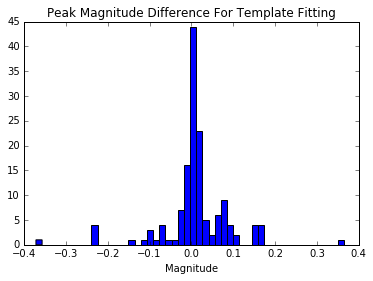

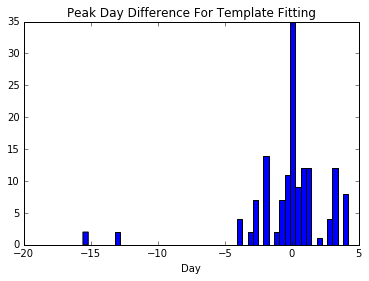

In [241]:
plt.figure()
plt.hist(peak_mag_difference['peak mag difference'], bins = 50)
plt.title('Peak Magnitude Difference For Template Fitting')
plt.xlabel('Magnitude')
plt.figure()
plt.hist(peak_day_difference['peak day difference'], bins = 50)
plt.title('Peak Day Difference For Template Fitting')
plt.xlabel('Day')

In [109]:
nll = lambda *args: -lnlike(*args)
result = optimize.minimize(nll, [max_mjd, max_mag], args=(mjds, mags, magerrs))
print result['x']

[  5.99999715e+04   2.00005504e+01]


In [112]:
def lnprior(theta):
    mjd, mag = theta
    if 50000 < mjd < 70000 and 10.0 < mag < 30.0:
        return 0.0
    return -np.inf

In [113]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [110]:
ndim, nwalkers = 2, 16
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
print(pos)

[array([  5.99999713e+04,   2.00004997e+01]), array([  5.99999715e+04,   2.00005427e+01]), array([  5.99999713e+04,   2.00005650e+01]), array([  5.99999715e+04,   2.00005986e+01]), array([  5.99999714e+04,   2.00004061e+01]), array([  5.99999716e+04,   2.00005960e+01]), array([  5.99999717e+04,   2.00006274e+01]), array([  5.99999713e+04,   2.00004790e+01]), array([  5.99999714e+04,   2.00003676e+01]), array([  5.99999716e+04,   2.00007831e+01]), array([  5.99999715e+04,   2.00004990e+01]), array([  5.99999715e+04,   2.00005960e+01]), array([  5.99999714e+04,   2.00004199e+01]), array([  5.99999714e+04,   2.00003982e+01]), array([  5.99999715e+04,   2.00004208e+01]), array([  5.99999715e+04,   2.00006176e+01])]


In [114]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mjds, mags, magerrs))

In [115]:
sampler.run_mcmc(pos, 500)

(array([[  5.99999677e+04,   2.00018193e+01],
        [  5.99999895e+04,   2.00014176e+01],
        [  5.99999631e+04,   2.00013475e+01],
        [  5.99999997e+04,   2.00016499e+01],
        [  5.99999425e+04,   2.00010408e+01],
        [  5.99999716e+04,   2.00013443e+01],
        [  5.99999597e+04,   1.99990841e+01],
        [  5.99999246e+04,   2.00010116e+01],
        [  5.99999853e+04,   1.99992154e+01],
        [  5.99999334e+04,   2.00012343e+01],
        [  5.99999596e+04,   1.99993366e+01],
        [  5.99999837e+04,   1.99996489e+01],
        [  6.00000048e+04,   1.99993880e+01],
        [  5.99999859e+04,   2.00014536e+01],
        [  6.00000026e+04,   2.00014188e+01],
        [  6.00000106e+04,   1.99999585e+01]]),
 array([-13072.01998381, -13072.00569484, -13071.62610228, -13072.71398387,
        -13072.13331017, -13071.58637335, -13072.46955318, -13073.35889901,
        -13072.20210612, -13072.75291684, -13072.15652435, -13071.75931106,
        -13072.77431272, -13071.91

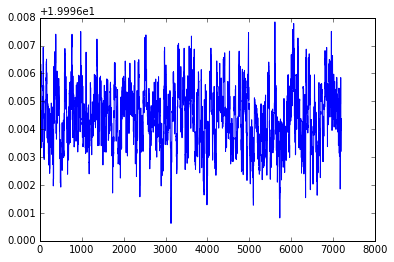

In [116]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
plt.plot(samples[:, 1])

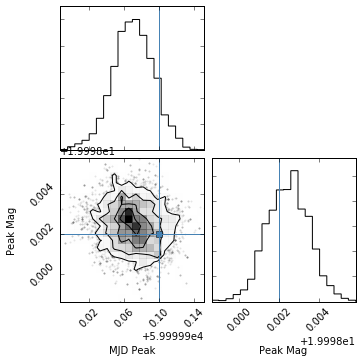

In [118]:
import corner
fig = corner.corner(samples, labels=["MJD Peak", "Peak Mag"],
                      truths=[60000, 20])